# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
from pathlib import Path
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pasta_dados = Path(r'C:\Users\mobishopgamer\Documents\RepositorioGitHub\Airbnb\Arquivos\dados')

dados_df = pd.DataFrame()

for arquivo in pasta_dados.iterdir():
    # Criando nome do mes e do ano
    mes = arquivo.name[:3] # 3 primeiras letras no nome do arquivo
    ano = re.findall(r'\d+', arquivo.name)[0] # encontrando sequencia de numeros no nome do arquivo e selecionando a primeira sequencia

    # Criando df de cada arquivo
    arquivo_df = pd.read_csv(arquivo)

    # Adc coluna com nome do mes e coluna com nome do ano
    arquivo_df['mes'] = mes
    arquivo_df['ano'] = ano

    # Juntando todos os df em um só
    dados_df = dados_df.append(arquivo_df)


C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\63840000.py:18: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  arquivo_df = pd.read_csv(arquivo)
C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\63840000.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dados_df = dados_df.append(arquivo_df)
C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\63840000.py:18: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  arquivo_df = pd.read_csv(arquivo)
C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\63840000.py:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dados_df = dados_df.append(arquivo_df)
C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\63840000.py:18: DtypeWarn

### Consolidar Base de Dados

In [2]:
# Criando uma planilha com 1000 linhas para analisar qualitativa em excel

dados_df.head(1000).to_csv('primeira_analise.csv', sep=';')

# Lembrando que o objetivo é julgar o valor do AirBnB, ou seja, podemos retirar as colunas que não vão impactgar no preço, como:
# - valores iguais ou parecidos em outra coluna
# - valores onde a maioria é nulo
# - textos desnecessários


### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [3]:
# Colunas relevantes selecionadas

col_relevantes =['host_response_time','host_response_rate','host_is_superhost','host_total_listings_count','latitude','longitude','property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type','amenities','price','weekly_price','monthly_price','security_deposit','cleaning_fee','guests_included','extra_people','minimum_nights','maximum_nights','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','instant_bookable','is_business_travel_ready','cancellation_policy','mes','ano']

dados_df = dados_df.loc[:, col_relevantes]

### Tratar Valores Faltando

In [4]:
# Descobrindo quantidade de valores NaN por colunas
print(dados_df.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_total_listings_count         460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
weekly_price                   826378
monthly_price                  818908
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_score

In [5]:
# Escluindo linhas onde temos mais de 300mil valores NaN
for col in dados_df:
    if dados_df[col].isnull().sum() > 300000:
        dados_df = dados_df.drop(col, axis=1)

print(dados_df.isnull().sum())
print(dados_df.shape) # mostra a quantidade de linhas e quantidade de colunas

host_is_superhost             460
host_total_listings_count     460
latitude                        0
longitude                       0
property_type                   0
room_type                       0
accommodates                    0
bathrooms                    1724
bedrooms                      850
beds                         2502
bed_type                        0
amenities                       0
price                           0
guests_included                 0
extra_people                    0
minimum_nights                  0
maximum_nights                  0
number_of_reviews               0
instant_bookable                0
is_business_travel_ready        0
cancellation_policy             0
mes                             0
ano                             0
dtype: int64
(902210, 23)


In [6]:
# Analisar se a quantidade de linhas NaN que restaram serão significativas
# Como a qntd de linhas NaN que restaram são poucas comparadas ao número total de linhas, vamos remover elas também

dados_df = dados_df.dropna()

print(dados_df.shape)

(897709, 23)


### Verificar Tipos de Dados em cada coluna

In [7]:
# Conferindo se o valor na priemira linha tem coesão com o tipo de dado da coluna

print(dados_df.dtypes)

host_is_superhost             object
host_total_listings_count    float64
latitude                     float64
longitude                    float64
property_type                 object
room_type                     object
accommodates                   int64
bathrooms                    float64
bedrooms                     float64
beds                         float64
bed_type                      object
amenities                     object
price                         object
guests_included                int64
extra_people                  object
minimum_nights                 int64
maximum_nights                 int64
number_of_reviews              int64
instant_bookable              object
is_business_travel_ready      object
cancellation_policy           object
mes                           object
ano                           object
dtype: object


In [8]:
print(dados_df.iloc[0])

host_is_superhost                                                            f
host_total_listings_count                                                  1.0
latitude                                                            -22.946854
longitude                                                           -43.182737
property_type                                                        Apartment
room_type                                                      Entire home/apt
accommodates                                                                 4
bathrooms                                                                  1.0
bedrooms                                                                   0.0
beds                                                                       2.0
bed_type                                                              Real Bed
amenities                    {TV,Internet,"Air conditioning",Kitchen,Doorma...
price                                               

In [9]:
# Convertendo os tipos de dados não coesos

# price
dados_df['price'] = dados_df['price'].str.replace('$', '')
dados_df['price'] = dados_df['price'].str.replace(',', '')
dados_df['price'] = dados_df['price'].astype(np.float32, copy=False)

# extra_people
dados_df['extra_people'] = dados_df['extra_people'].str.replace('$', '')
dados_df['extra_people'] = dados_df['extra_people'].str.replace(',', '')
dados_df['extra_people'] = dados_df['extra_people'].astype(np.float32, copy=False)

# ano
dados_df['ano'] = dados_df['ano'].astype(np.int32)

tipos = dados_df.dtypes

for col in dados_df.columns:
    if dados_df[col].dtype == 'float64':
        dados_df[col] = dados_df[col].astype(np.float32, copy=False)
    elif dados_df[col].dtype == 'int64':
        dados_df[col] = dados_df[col].astype(np.int32, copy=False)

print(dados_df.dtypes)

C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\1198152649.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dados_df['price'] = dados_df['price'].str.replace('$', '')
C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\1198152649.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dados_df['extra_people'] = dados_df['extra_people'].str.replace('$', '')


host_is_superhost             object
host_total_listings_count    float32
latitude                     float32
longitude                    float32
property_type                 object
room_type                     object
accommodates                   int32
bathrooms                    float32
bedrooms                     float32
beds                         float32
bed_type                      object
amenities                     object
price                        float32
guests_included                int32
extra_people                 float32
minimum_nights                 int32
maximum_nights                 int32
number_of_reviews              int32
instant_bookable              object
is_business_travel_ready      object
cancellation_policy           object
mes                           object
ano                            int32
dtype: object


### Análise Exploratória e Tratar Outliers

1. Correlacionar as colunas para sabermos como elas impactam no nosso objetivo.
2. Exluir outliers (deve ser feito uma análise qualitativa antes de exluí-los)

##### Cálculo outliers:
- Quartil1 = 25%, Quartil2 = 50%, Quartil3 = 75%, Quartil4 = 100% -> com base nos valores analisados
- Amplitude = Quartil3 - Quartil1 -> valores entre 25% e 75%
- Outlier = valores menores que Q1 - (1.5 * Amplitude) e maiores que Q3 + (1.5 * Amplitude)


C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\509798000.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlaçao = dados_df.corr()


<AxesSubplot: >

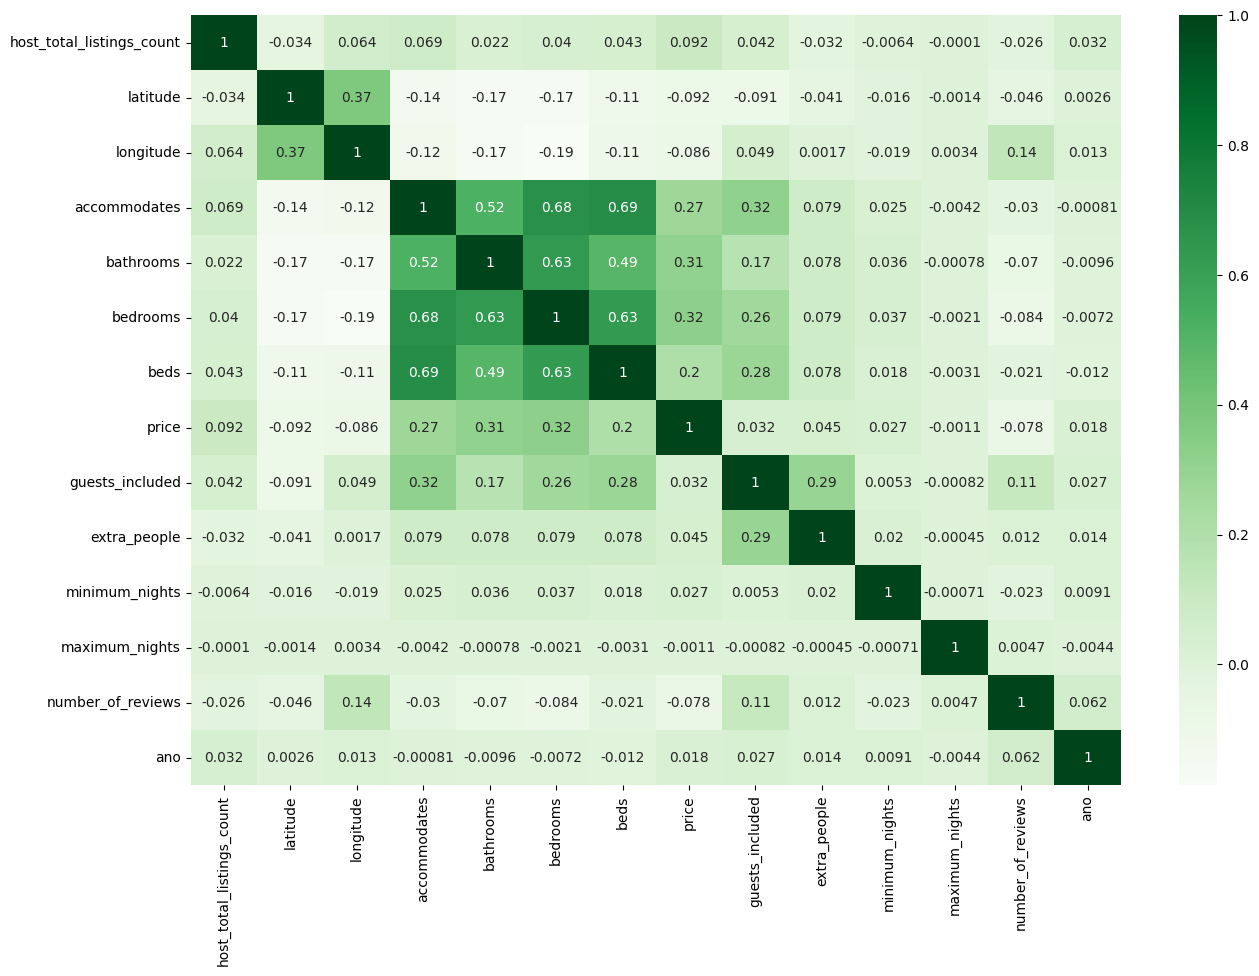

In [10]:
# Criando correlação
correlaçao = dados_df.corr()

# Configurando gráfico de calor das correlações
plt.figure(figsize=(15, 10)) # tamanho 15x10
sns.heatmap(correlaçao, annot=True, cmap='Greens')


##### Outliers que serão exclídos:

- Valores de preço de hospedagem e de pessoa extra acima do limite superior, pois este modelo é destinado apenas para imóveis comuns, ou seja, se quisermos selecionar imóveis acima do padrão/de luxo teremos que criar outro modelo
- Hosts com mais de 6 imóveis tem mais chance de ser de imobiliárias/profissionais, o que não está dentro do objetivo principal
- Remover coluna onde os limites inferior e superior do outlier sejam o mesmo valor, podendo ser um problema de preenchimento de dados no airbnb, o que pode atrapalhar nosso modelo.

In [11]:
# Criando função para calcular outliers(ponto fora da curva)
def limites_outlier(coluna):
    q1 = coluna.quantile(0.25) 
    q3 = coluna.quantile(0.75)
    # .qualitle -> calculo do quantil dos dados a partir do arg específicado

    amplitude = q3 - q1

    limite_inferior = q1 - 1.5 * amplitude
    limite_superior = q3 + 1.5 * amplitude

    return limite_inferior, limite_superior

# Criando Função para criar gráficos
def diagrama_grafic(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # figura, (eixo_grafico1, eixo_grafico2)

    # configurando tamanho
    fig.set_size_inches(15, 5)

    # gráfico 1
    sns.boxplot(x=coluna, ax=ax1) # x=informação base do gráfico, ax=eixo

    # gráfico 2
    ax2.set_xlim(limites_outlier(coluna)) # configurando eixo 2
    sns.boxplot(x=coluna, ax=ax2)

def histogramam_grafic(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(data = dados_df, x=coluna, element='bars')

def grafico_barra(coluna):
    plt.figure(figsize=(10, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    # .value_counts() -> conta a quantidade de todos os valores iguais e o index seria os valores distintos
    
    ax.set_xlim(limites_outlier(coluna))

# Criando função para excluir outlier
def drop_outlier(df, coluna_name):
    # apresentando quantidade de linhas totais da coluna
    qntd_linhas = df.shape[0]

    # apresentando limites do outlier da coluna
    limite_inf, limite_sup = limites_outlier(df[coluna_name])

    # criando df com linhas dentro do limite do outlier
    df = df.loc[(df[coluna_name] >= limite_inf) & (df[coluna_name] <= limite_sup), :]

    # Calculando qntd de linhas removidas
    linhas_remov = qntd_linhas - df.shape[0]
    
    return df, linhas_remov


Ordem de analise:
    valores de preço -> demais valores numéricos -> colunas de textos

#### Coluna Price

count    897709.000000
mean        647.922241
std        1705.998169
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64
--------------------------------------------------
(-524.0, 1276.0)


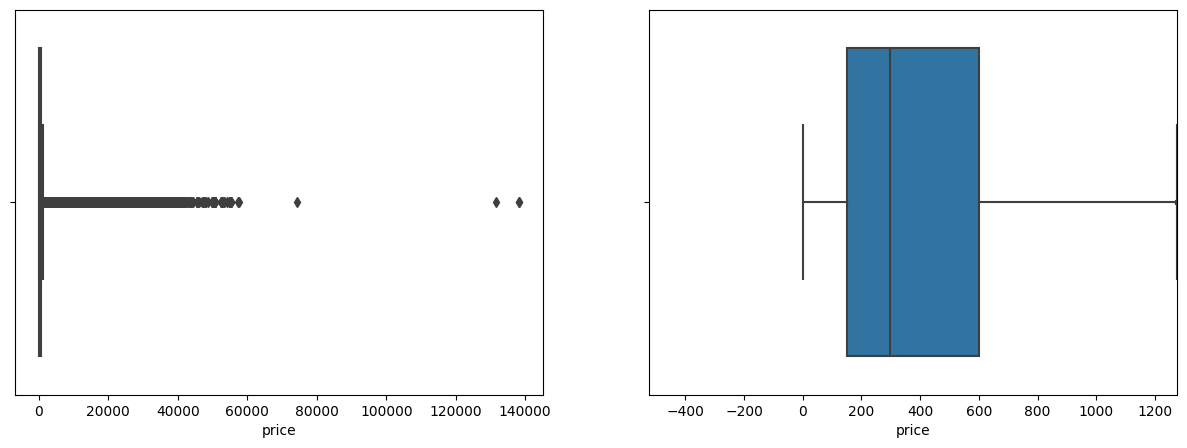

In [12]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['price'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['price']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['price'])


In [13]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'price')

print(f'Drop row = {lin_removidas}')

Drop row = 87282


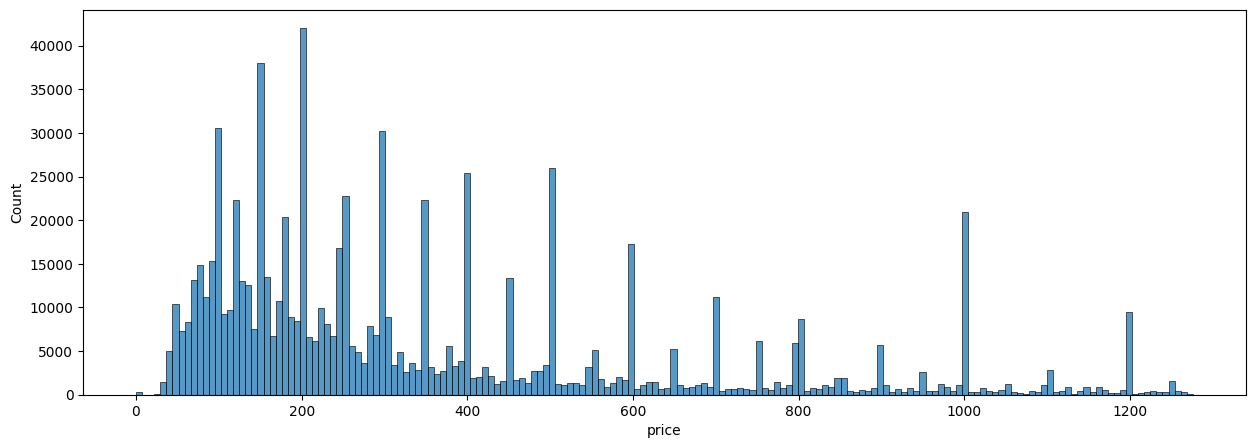

In [14]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
histogramam_grafic(dados_df['price'])

#### Coluna Extra people

count    810427.000000
mean         38.393246
std          84.558319
min           0.000000
25%           0.000000
50%           0.000000
75%          50.000000
max        5631.000000
Name: extra_people, dtype: float64
--------------------------------------------------
(-75.0, 125.0)


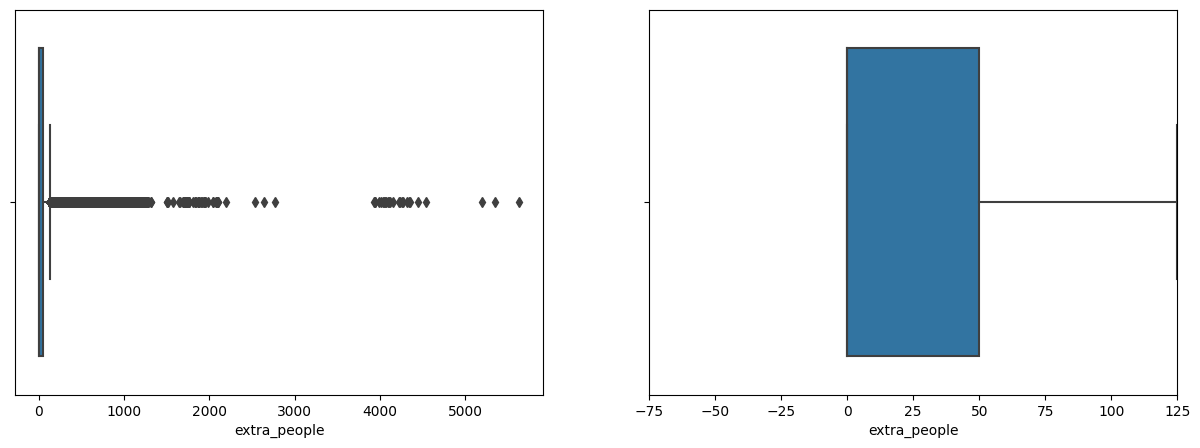

In [15]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['extra_people'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['extra_people']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['extra_people'])

In [16]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'extra_people')

print(f'Drop row = {lin_removidas}')

Drop row = 59194


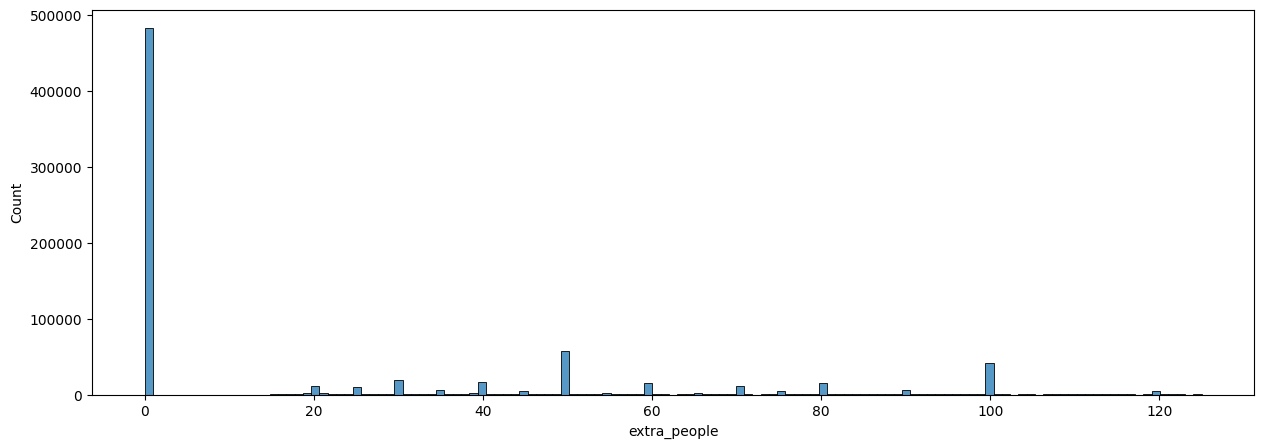

In [17]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
histogramam_grafic(dados_df['extra_people'])

#### Coluna Host Listings Count

count    751233.000000
mean          8.012903
std          33.823631
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max        1321.000000
Name: host_total_listings_count, dtype: float64
--------------------------------------------------
(-2.0, 6.0)


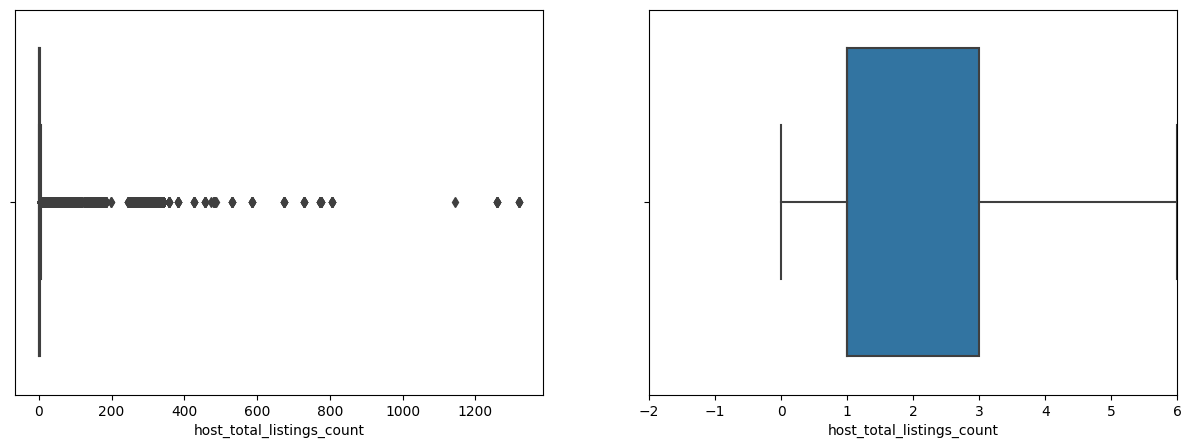

In [18]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['host_total_listings_count'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['host_total_listings_count']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['host_total_listings_count'])

In [19]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'host_total_listings_count')

print(f'Drop row = {lin_removidas}')

Drop row = 97723


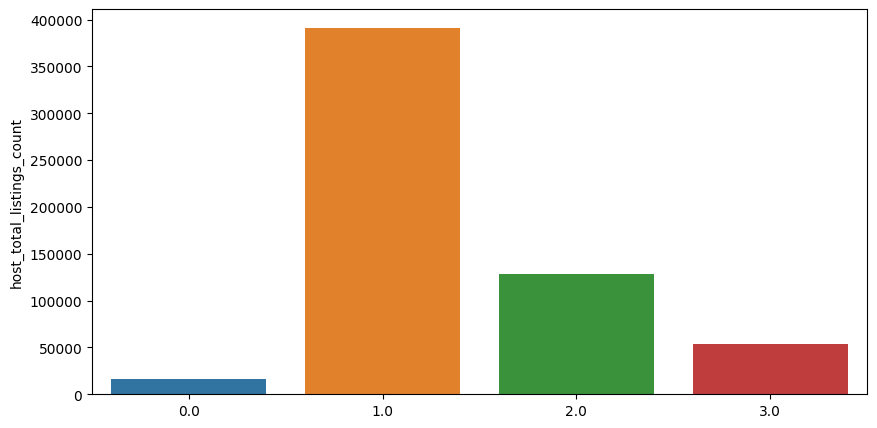

In [20]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
grafico_barra(dados_df['host_total_listings_count'])

#### Coluna Accommodates

count    653510.000000
mean          3.746402
std           2.079308
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max          16.000000
Name: accommodates, dtype: float64
--------------------------------------------------
(-2.5, 9.5)


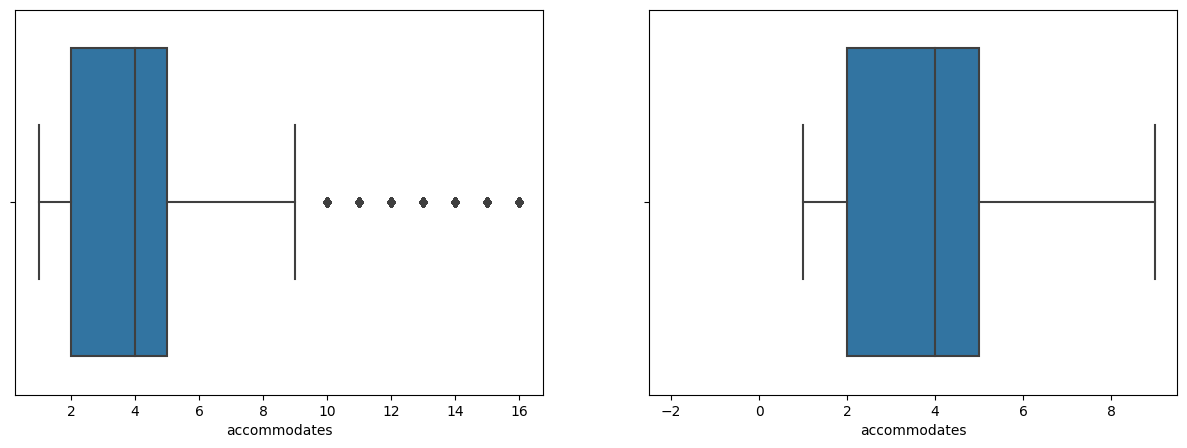

In [21]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['accommodates'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['accommodates']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['accommodates'])

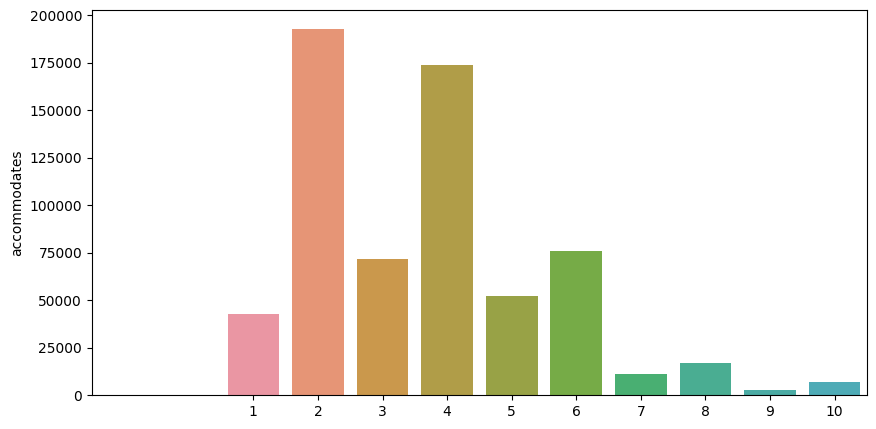

In [22]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
grafico_barra(dados_df['accommodates'])

In [23]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'accommodates')

print(f'Drop row = {lin_removidas}')

Drop row = 13146


#### Coluna Bathrooms

count    640364.000000
mean          1.479690
std           0.711147
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          22.000000
Name: bathrooms, dtype: float64
--------------------------------------------------
(-0.5, 3.5)


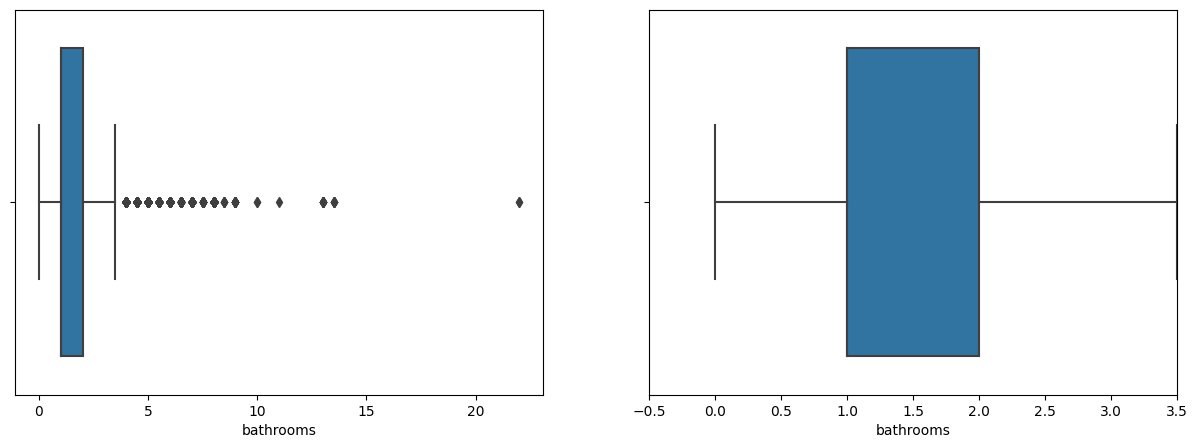

In [24]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['bathrooms'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['bathrooms']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['bathrooms'])

<AxesSubplot: ylabel='bathrooms'>

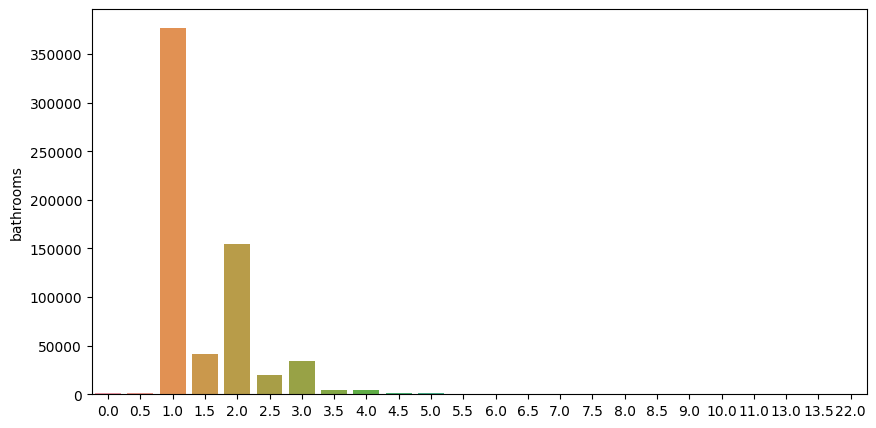

In [25]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
plt.figure(figsize=(10, 5))
sns.barplot(x=dados_df['bathrooms'].value_counts().index, y=dados_df['bathrooms'].value_counts())

In [26]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'bathrooms')

print(f'Drop row = {lin_removidas}')

Drop row = 6894


#### Coluna Bedrooms

count    633470.000000
mean          1.412526
std           0.790204
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          13.000000
Name: bedrooms, dtype: float64
--------------------------------------------------
(-0.5, 3.5)


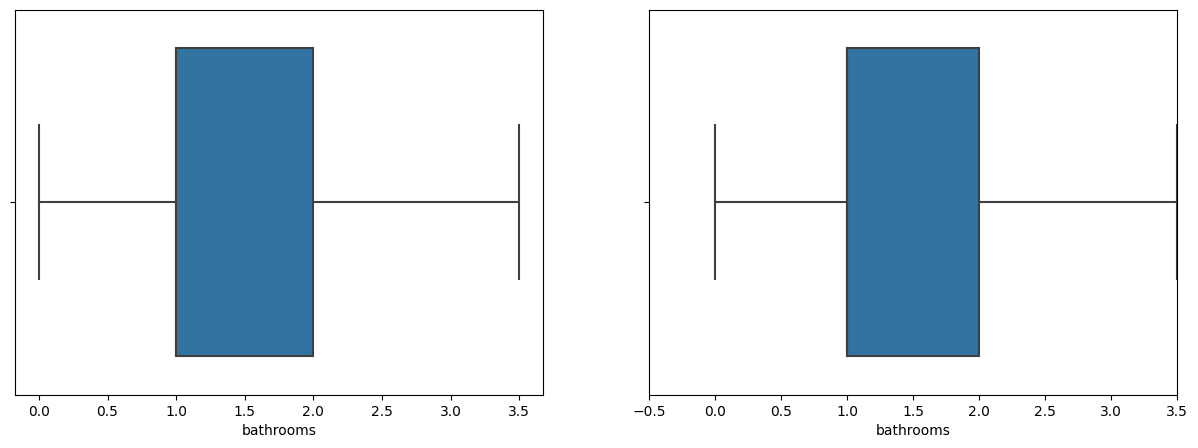

In [27]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['bedrooms'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['bedrooms']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['bathrooms'])

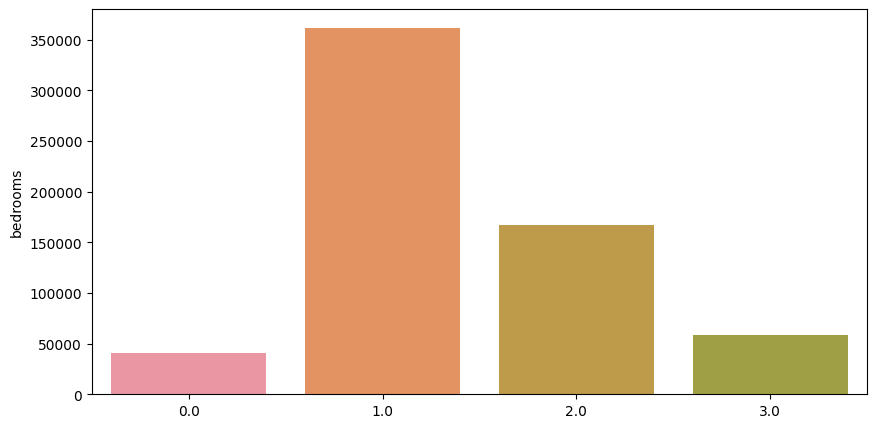

In [28]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
grafico_barra(dados_df['bedrooms'])

In [29]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'bedrooms')

print(f'Drop row = {lin_removidas}')

Drop row = 5482


#### Coluna Beds

count    627988.000000
mean          2.167928
std           1.342147
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          25.000000
Name: beds, dtype: float64
--------------------------------------------------
(-2.0, 6.0)


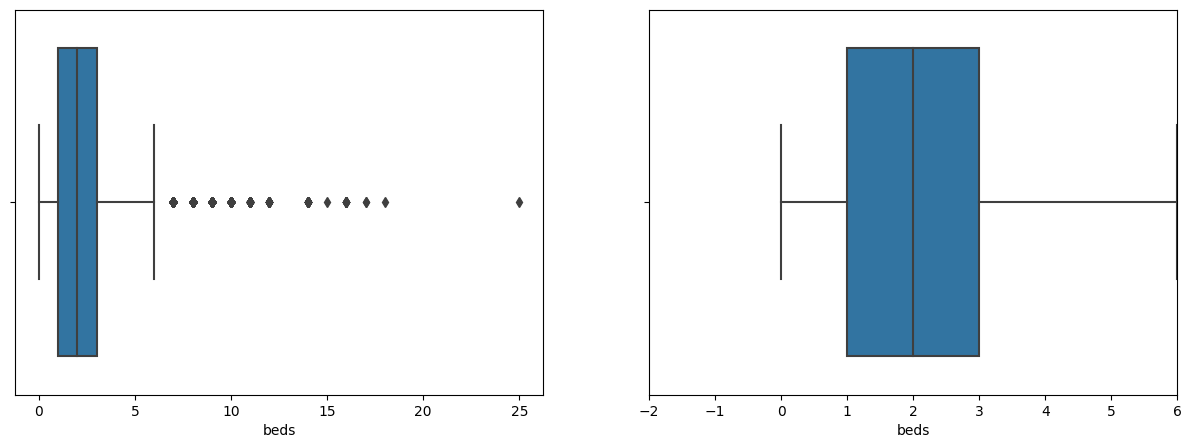

In [30]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['beds'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['beds']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['beds'])

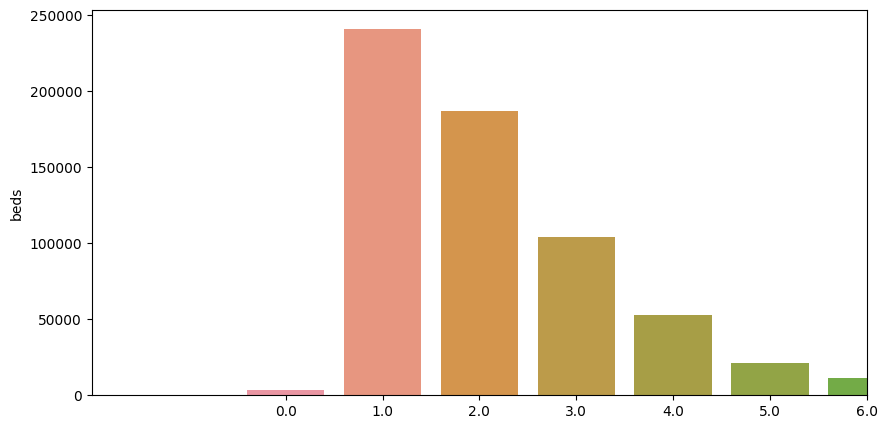

In [31]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
grafico_barra(dados_df['beds'])

In [32]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'beds')

print(f'Drop row = {lin_removidas}')

Drop row = 5622


#### Coluna Guests Included (convidados)

count    622366.000000
mean          1.470194
std           1.076435
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          16.000000
Name: guests_included, dtype: float64
--------------------------------------------------
(1.0, 1.0)


C:\Users\mobishopgamer\AppData\Local\Temp\ipykernel_664\2037983942.py:26: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax2.set_xlim(limites_outlier(coluna)) # configurando eixo 2


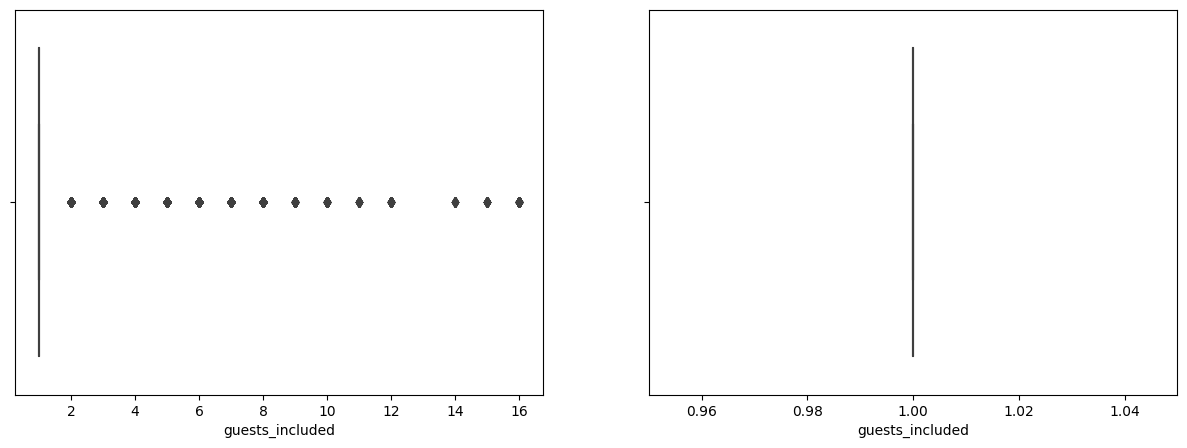

In [33]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['guests_included'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['guests_included']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['guests_included'])

In [34]:
# Escluindo coluna guests_included pois o valores de limites são os mesmos
dados_df = dados_df.drop('guests_included', axis=1)
dados_df.shape

(622366, 22)

#### Coluna Minimum Nights x Maximum Nights

count    622366.000000
mean          4.220158
std          18.742736
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        1224.000000
Name: minimum_nights, dtype: float64
--------------------------------------------------
(-3.5, 8.5)


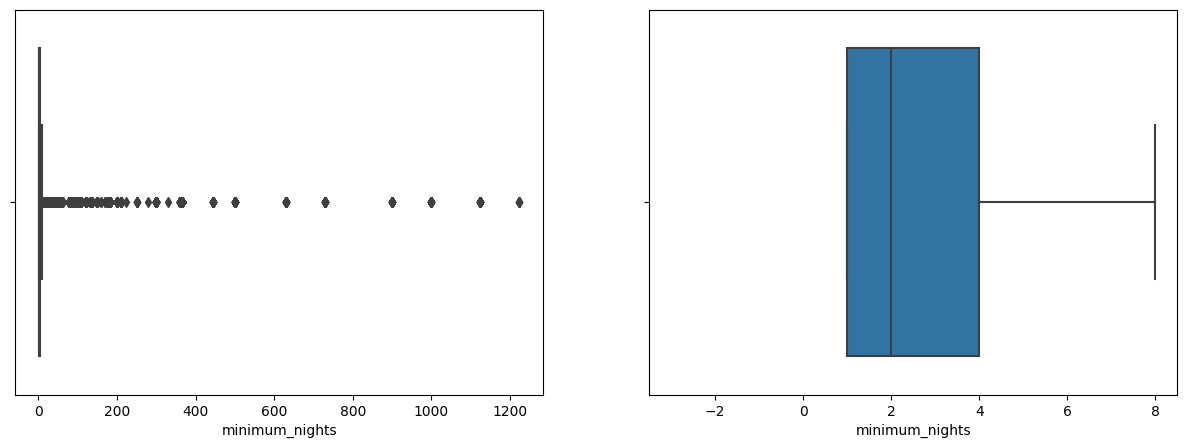

In [35]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['minimum_nights'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['minimum_nights']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['minimum_nights'])

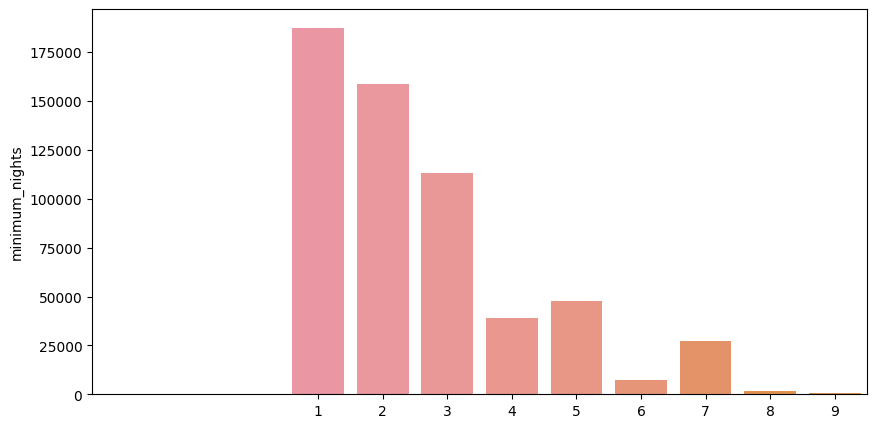

In [36]:
# Coluna na função de gráfico hitograma para enxergar melhor os valores após remover outliers
grafico_barra(dados_df['minimum_nights'])

In [37]:
# Coluna na função de remover os outliers
dados_df, lin_removidas = drop_outlier(dados_df, 'minimum_nights')

print(f'Drop row = {lin_removidas}')

Drop row = 40383


In [38]:
# Escluindo coluna maximum_nights, pois as informações de minimum_nights já foram suficientes para o nosso modelo, ou seja, não estamos procurando logas estadias
dados_df = dados_df.drop('maximum_nights', axis=1)
dados_df.shape

(581983, 21)

#### Coluna Number of Reviews

count    581983.000000
mean          9.020882
std          23.699781
min           0.000000
25%           0.000000
50%           1.000000
75%           6.000000
max         392.000000
Name: number_of_reviews, dtype: float64
--------------------------------------------------
(-9.0, 15.0)


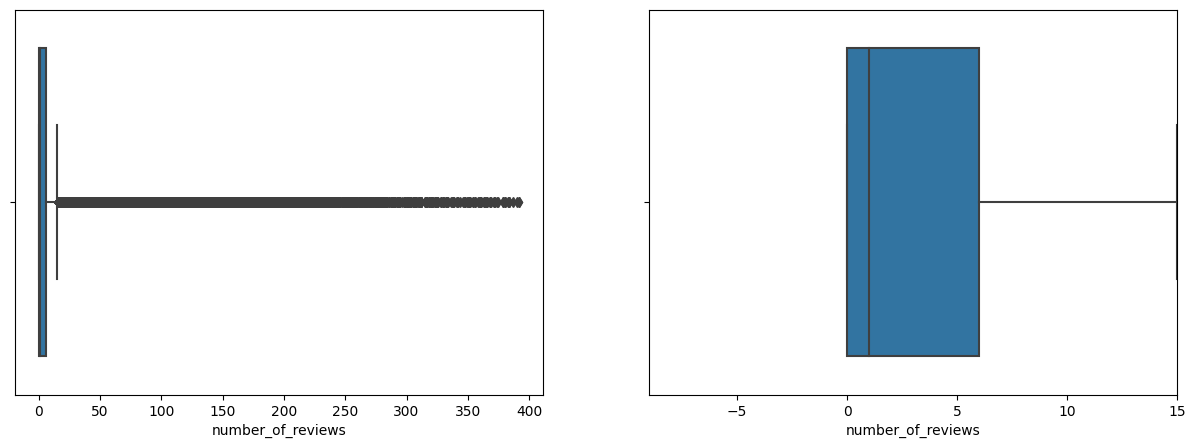

In [39]:
# Início passo a passo para enxergar e remover outlier coluna de preço

print(dados_df['number_of_reviews'].describe())

print(50*'-')

# Excutando função outlier na coluna
print(limites_outlier(dados_df['number_of_reviews']))

# Coluna na função de gráfico para enxergar valores totais / outlier delimitado
diagrama_grafic(dados_df['number_of_reviews'])

In [ ]:
# Os outliers da coluna de 'number_of_reviews' não serão removidos, pois os reviews acima do limite superior representa um feedback cada vez melhor do imóvel

#### Coluna Property Type

Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                      34
Resort    

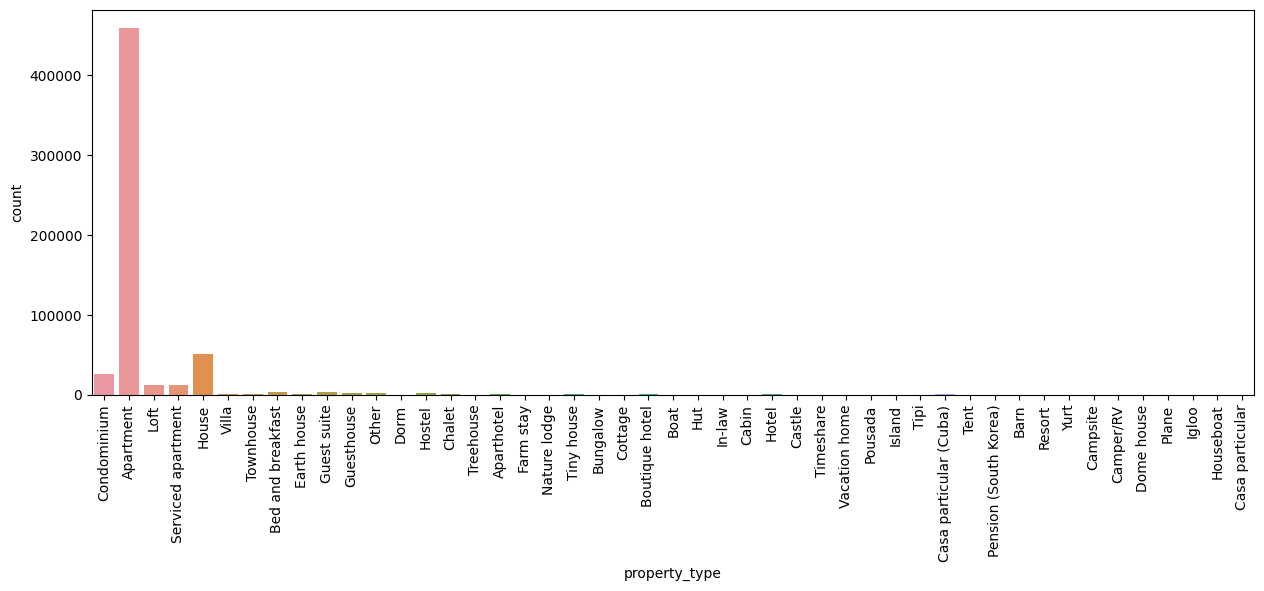

In [49]:
# Exibindo os textos encontrados nessa coluna
tipo_imovel = dados_df['property_type'].value_counts()
print(tipo_imovel)

# Exibindo em gráfico
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=dados_df['property_type'])
grafico.tick_params(axis='x', rotation=90)
# .tick_params(eixo x ou y, rotação em graus) -> marcação no eixo do grafico


In [52]:
# Todos os tipos de propriedades abaixo de 2000 unidades, serão considerados como 'Outros'

# Criando lista com 'property_type' abaixo de 2000 linhas
propriedades_agrupadas = []
for tipo in tipo_imovel.index:
    if tipo_imovel[tipo] < 2000:
        propriedades_agrupadas.append(tipo)

# # Agrupando em coluna 'Outros'
for tipo1 in propriedades_agrupadas:
    dados_df.loc[dados_df['property_type'] == tipo1, 'property_type'] = 'Outros'

print(dados_df['property_type'].value_counts())

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


### Encoding

### Modelo de Previsão

### Análise do Melhor Modelo

### Ajustes e Melhorias no Melhor Modelo